## Imports

In [1]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    perform_pca,
    feature_importance_plot,
)
from subpred.cdhit import cd_hit

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose = True,
    tax_ids_filter = [3702],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
    # sequence_clustering = 70
)
df.columns

Index(['keywords_transport', 'keywords_location', 'keywords_transport_related',
       'gene_names', 'protein_names', 'tcdb_id', 'tcdb_class', 'organism_id',
       'sequence'],
      dtype='object')

<AxesSubplot:xlabel='identity_threshold', ylabel='count'>

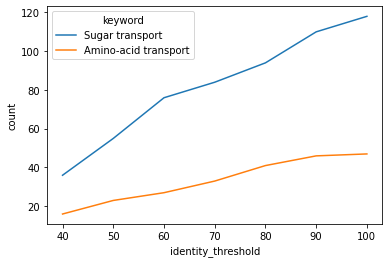

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

df_stats_long = get_clustering_stats(df)

sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

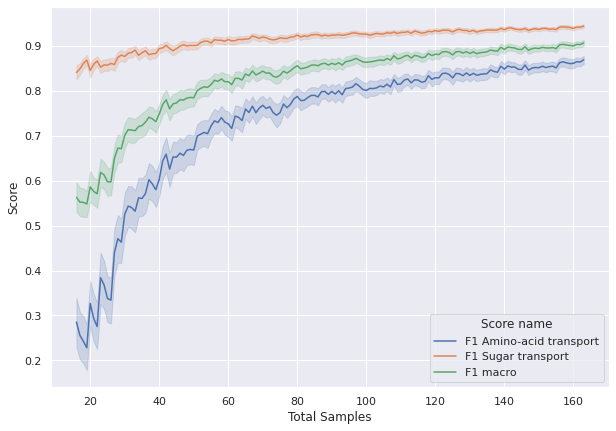

In [12]:
def downsampling_plot(
    df_features,
    labels: pd.Series,
    min_features=16,
    random_seeds=list(range(50)),
    figsize=(10, 7),
):
    """
    Perform downsampling and evaluation, until number of samples reaches min_features.
    """
    def test_case(df_features, labels, n_samples, random_seed):
        df_features_sampled, _, labels_sampled, _ = train_test_split(
            df_features,
            labels,
            stratify=labels,
            random_state=random_seed,
            train_size=n_samples,
            shuffle=True,
        )
        label_encoder = LabelEncoder()
        X = df_features_sampled.to_numpy()
        y = label_encoder.fit_transform(labels_sampled)

        estimator = make_pipeline(StandardScaler(), SVC(class_weight="balanced"))
        scorers_dict = dict()
        labels_unique = labels.unique()
        labels_unique_numerical = label_encoder.transform(labels_unique)
        for label, label_numerical in zip(labels_unique, labels_unique_numerical):
            scorers_dict[f"F1 {label}"] = make_scorer(
                f1_score, pos_label=label_numerical
            )

        scorers_dict["F1 macro"] = make_scorer(f1_score, average="macro")

        records = []
        for scorer_name, scorer in sorted(scorers_dict.items()):
            cv_results = cross_val_score(estimator, X, y, n_jobs=1, scoring=scorer)
            for cv_result in cv_results:
                records.append([scorer_name, n_samples, cv_result])
        return records

    n_samples_list = list(range(min_features, df_features.shape[0] - 1))
    records_list = Parallel(n_jobs=-1)(
        delayed(test_case)(df_features, labels, n_samples, random_seed)
        for n_samples in n_samples_list
        for random_seed in random_seeds
    )
    records = []
    for sl in records_list:
        for ssl in sl:
            records.append(ssl)
    results_df = pd.DataFrame.from_records(
        records, columns=["Score name", "Total Samples", "Score"],
    )
    plt.figure(figsize=figsize)
    sns.set_theme()
    # sns.set(font_scale=2)
    g = sns.lineplot(data=results_df, x="Total Samples", y="Score", hue="Score name",)


df_aac_100 = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")

downsampling_plot(df_aac_100, labels)


<AxesSubplot:xlabel='|Amino-acid transport|/|Sugar transport|', ylabel='Score'>

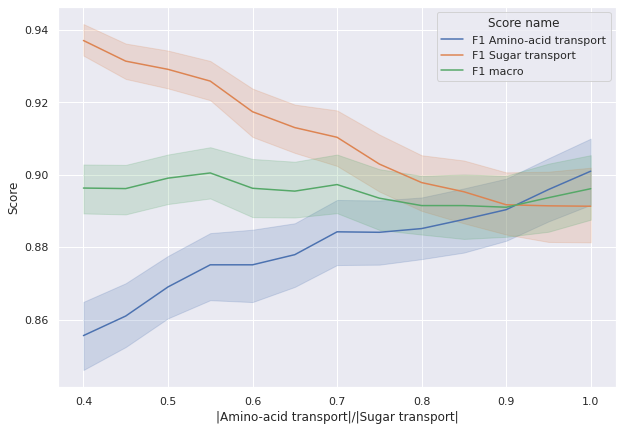

In [6]:
from subpred.plots import downsample_majority_class_plot


# df_feature_unclustered = calculate_aac(df.sequence)
# labels = df.keywords_transport.rename("labels")
# min_class_sample_fractions = ([x / 100 for x in range(40, 101, 5)],)
# random_seeds = list(range(50))

df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
downsample_majority_class_plot(df_aac, labels, n_jobs=-1)

# plt.savefig("plots/athaliana_sugar_amino_cluster100_aac_downsampling.png", dpi=300)
